In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
import keras
import os
import pandas as pd, numpy as np
import cv2, imutils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from hyperopt.pyll.base import scope 
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import os

In [3]:
cwd = os.getcwd()
df = pd.read_csv(cwd + "/augmentation_data.csv")

In [ ]:
df

In [4]:
import cv2, math, numpy as np, dlib
from imutils import face_utils

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/../predictor/shape_predictor_68_face_landmarks.dat")

In [5]:
error = []

pixels =  []
labels = []
for i, row in df.iterrows():
    image_path = cwd + "/augmentation/" + row['image']
    label = row['emotion']

    image = cv2.imread(image_path)

    # detect face in grayscale image
    rect = detector(image, 1)
    
    if len(rect) == 0:
        error.append(i)
        continue

    shape = predictor(image, rect[0])
    np_shape = face_utils.shape_to_np(shape)

    x = list(j[0].item() for j in np_shape)
    y = list(j[1].item() for j in np_shape)

    # np_shape = np.array(np_shape).flatten()
    # roi_points.append(np_shape)

    try:
        # crop image
        image = image[int(min(y)):int(max(y)), int(min(x)):int(max(x))]

        # resize
        image = cv2.resize(image, (112, 112), interpolation = cv2.INTER_AREA)

        pixel = image.flatten()
        pixels.append(pixel)
        labels.append(label)

    except:
        error.append(i)
        continue

    if i > 0 and i % 10000 == 0:
        print('[INFO] processed {}/{}'.format(i, len(df)))

In [ ]:
df.drop(error, axis=0, inplace=True)

In [ ]:
df.to_csv(cwd + "/crop_data.csv", index=False)

In [6]:
df = pd.read_csv(cwd + "/crop_data.csv")

In [ ]:
df

In [7]:
df.groupby('emotion').count()

,image
emotion,
0,9013
1,8510
2,9185
3,9434
4,9181
5,9092
6,9186
7,8108


In [17]:
pixels =  []
labels = []
for i, row in df.iterrows():
    image_path = cwd + "/augmentation/" + row['image']
    label = row['emotion']

    image = cv2.imread(image_path)

    # detect face in grayscale image
    rect = detector(image, 1)
    
    if len(rect) == 0:
        error.append(i)
        continue

    shape = predictor(image, rect[0])
    np_shape = face_utils.shape_to_np(shape)

    x = list(j[0].item() for j in np_shape)
    y = list(j[1].item() for j in np_shape)

    # crop image
    image = image[int(min(y)):int(max(y)), int(min(x)):int(max(x))]

    # resize
    image = cv2.resize(image, (112, 112), interpolation = cv2.INTER_AREA)

    pixel = image.flatten()
    pixels.append(pixel)
    labels.append(label)

    if i > 0 and i % 10000 == 0:
        print('[INFO] processed {}/{}'.format(i, len(df)))

[INFO] processed 10000/71709
[INFO] processed 20000/71709
[INFO] processed 30000/71709
[INFO] processed 40000/71709
[INFO] processed 50000/71709
[INFO] processed 60000/71709
[INFO] processed 70000/71709


In [8]:
import os
import cv2

cwd = os.getcwd()

image_path = cwd + "/augmentation/SURPRISE/" + 'surprise (10)_2856.jpg'
image = cv2.imread(image_path)

# plot coordinate
rect = detector(image, 1)
shape = predictor(image, rect[0])
np_shape = face_utils.shape_to_np(shape)

for (x, y) in np_shape:
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

x = list(j[0].item() for j in np_shape)
y = list(j[1].item() for j in np_shape)

start_point = (int(min(x)), int(min(y)))
end_point = (int(max(x)), int(max(y)))
color = (0, 255, 0)
thickness = 2

image = cv2.rectangle(image, start_point, end_point, color, thickness)

cv2.imwrite(cwd + '/augmentation/plot_coordinate.jpg', image)

# crop image
image = cv2.imread(image_path)
        


image = image[int(min(y)):int(max(y)), int(min(x)):int(max(x))]
image = cv2.resize(image, (112, 112), interpolation = cv2.INTER_AREA)

cv2.imwrite(cwd + '/augmentation/crop.jpg', image)

True

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(pixels), np.array(labels), test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [9]:
from hyperopt.pyll.base import scope
from hyperopt import hp

space = {
    'rate'       : hp.uniform('rate', 0.01, 0.5),
    'dropout'    : hp.uniform('dropout', 0.01, 0.5),
    'units1'      : scope.int(hp.quniform('units1', 10, 100, 5)),
    'units2'      : scope.int(hp.quniform('units2', 10, 100, 5)),
    'units3'      : scope.int(hp.quniform('units3', 10, 100, 5)),
    'units4'      : scope.int(hp.quniform('units4', 10, 100, 5)),
    'batch_size' : scope.int(hp.quniform('batch_size', 100, 250, 25)),
    'layers'     : scope.int(hp.quniform('layers', 3, 4, 1)),
    'optimizer'  : hp.choice('optimizer', ['adam', 'adadelta', 'sgd', 'RMSprop']),
    'epochs'     : scope.int(hp.quniform('epochs', 100, 300, 10)),
    'activation' : hp.choice('activation', ['relu']), # ['relu', 'sigmoid', 'tanh', 'elu']
}

In [10]:
def f_nn(params):
    print("params", params)

    # Keras LSTM model
    model = Sequential()

    # params['layers'] => layer of model (do not count input layer)

    if params['layers'] == 1:
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        #model.add(keras.layers.BatchNormalization())
        #model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        #model.add(keras.layers.BatchNormalization())
        #model.add(Dropout(rate=params['rate']))

        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(Dense(params['units' + str(i + 2)], activation=params['activation']))
            #model.add(keras.layers.BatchNormalization())
            #model.add(Dropout(rate=params['rate']))

        # Last layer doesn't return anything                                            
        model.add(Dense(params['units' + str(params['layers'])], activation=params['activation']))
        #model.add(keras.layers.BatchNormalization())
        model.add(Dropout(rate=params['rate']))

    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=params['optimizer'], loss='mean_squared_error', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=15)
    result =  model.fit(X_train, y_train, validation_data=(X_val, y_val,), batch_size=params['batch_size'], epochs=params['epochs'], verbose=0, callbacks=[es])

    # Get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)

    return {'loss': validation_loss, 
            'status': STATUS_OK, 
            'model': model, 
            'params': params}

In [11]:
# Running Hyperparameter
trials = Trials()
best = fmin(f_nn, 
            space, 
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)
print(best)

params                                                
{'activation': 'relu', 'batch_size': 200, 'dropout': 0.27787543365509093, 'epochs': 140, 'layers': 3, 'optimizer': 'adam', 'rate': 0.11422298295745298, 'units1': 45, 'units2': 55, 'units3': 100, 'units4': 30}
Epoch 00016: early stopping                           
Best validation loss of epoch:                        
0.21848852932453156                                   
params                                                                             
{'activation': 'relu', 'batch_size': 175, 'dropout': 0.28566092346280336, 'epochs': 150, 'layers': 4, 'optimizer': 'RMSprop', 'rate': 0.4097428974768156, 'units1': 55, 'units2': 45, 'units3': 50, 'units4': 95}
Epoch 00021: early stopping                                                        
Best validation loss of epoch:                                                     
0.21831423044204712                                                                
params                   

In [12]:
best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']

In [13]:
print(best_model)
print(best_params)

{'activation': 'relu', 'batch_size': 175, 'dropout': 0.34388418124365483, 'epochs': 210, 'layers': 3, 'optimizer': 'adadelta', 'rate': 0.1504233579104983, 'units1': 35, 'units2': 55, 'units3': 65, 'units4': 50}


In [21]:
def create_model_best_param(params, output):
    '''
    model = Sequential()
    model.add(Dense(params['units1'],
                    #kernel_initializer='he_uniform',
                    #kernel_regularizer=tf.keras.regularizers.l1(0.2),
                    activation=params['activation'],
                    input_shape=(X_train.shape[1],)))
    model.add(keras.layers.BatchNormalization())

    model.add(Dense(params['units2'],
                    activation=params['activation'])) 
    model.add(keras.layers.BatchNormalization())
                                          
    model.add(Dense(params['units3'],
                    activation=params['activation']))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(rate=params['rate']))

    if(params['optimizer'] == 'adam'):
        opt = keras.optimizers.Adam(learning_rate=params['rate'])
    if(params['optimizer'] == 'adadelta'):
        opt = keras.optimizers.Adadelta(learning_rate=params['rate'])
    if(params['optimizer'] == 'sgd'):
        opt = keras.optimizers.SGD(learning_rate=params['rate'])
    if(params['optimizer'] == 'RMSprop'):
        opt = keras.optimizers.RMSprop(learning_rate=params['rate'])

    model.add(Dense(8,
                    #kernel_initializer = 'glorot_uniform',
                    activity_regularizer=tf.keras.regularizers.L2(0.2),
                    activation='softmax'))
    model.compile(#optimizer=params['optimizer'],
                    optimizer=opt,
                    loss='mean_squared_error',
                    metrics=['accuracy'])
    '''
    model = Sequential()

    # params['layers'] => layer of model (do not count input layer)

    if params['layers'] == 1:
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        model.add(keras.layers.BatchNormalization())
        #model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        model.add(keras.layers.BatchNormalization())
        #model.add(Dropout(rate=params['rate']))

        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(Dense(params['units' + str(i + 2)], activation=params['activation']))
            model.add(keras.layers.BatchNormalization())
            #model.add(Dropout(rate=params['rate']))

        # Last layer doesn't return anything                                            
        model.add(Dense(params['units' + str(params['layers'])], activation=params['activation']))
        model.add(keras.layers.BatchNormalization())
        model.add(Dropout(rate=params['rate']))

    model.add(Dense(output, activation='softmax'))
    model.compile(optimizer=params['optimizer'], loss='mean_squared_error', metrics=['accuracy'])
    
    return model

In [23]:
# hyper
# best_params = {'activation': 'relu', 'batch_size': 100, 'dropout': 0.32861926166398264, 'epochs': 220, 'layers': 3, 'optimizer': 'adam', 'rate': 0.291437838589817, 'units1': 100, 'units2': 90, 'units3': 40, 'units4': 35} # val20% acc 0.5632 | val10+kerenel 0.5066
# best_params = {'activation': 'relu', 'batch_size': 150, 'dropout': 0.32861926166398264, 'epochs': 220, 'layers': 3, 'optimizer': 'adam', 'rate': 0.291437838589817, 'units1': 100, 'units2': 90, 'units3': 40, 'units4': 35} # acc = 0.5483 
# best_params = {'activation': 'relu', 'batch_size': 200, 'dropout': 0.32861926166398264, 'epochs': 220, 'layers': 3, 'optimizer': 'adam', 'rate': 0.291437838589817, 'units1': 120, 'units2': 100, 'units3': 40, 'units4': 35} # 0.5066
# best_params = {'activation': 'relu', 'batch_size': 100, 'dropout': 0.32861926166398264, 'epochs': 220, 'layers': 3, 'optimizer': 'adam', 'rate': 0.291437838589817, 'units1': 180, 'units2': 120, 'units3': 50, 'units4': 35} # 0.51
# best_params = {'activation': 'relu', 'batch_size': 200, 'dropout': 0.32861926166398264, 'epochs': 220, 'layers': 3, 'optimizer': 'adam', 'rate': 0.291437838589817, 'units1': 100, 'units2': 100, 'units3': 50, 'units4': 35}
# best_param = {'activation': 'relu', 'batch_size': 200, 'dropout': 0.1460376261825793, 'epochs': 280, 'layers': 3, 'optimizer': 'adadelta', 'rate': 0.0020694944392570737, 'units1': 85, 'units2': 65, 'units3': 40, 'layers': 3} # acc = 0.5387 | output L2(0.2) 0.5524
# best_param = {'activation': 'relu', 'batch_size': 175, 'dropout': 0.34388418124365483, 'epochs': 210, 'layers': 3, 'optimizer': 'adadelta', 'rate': 0.1504233579104983, 'units1': 35, 'units2': 55, 'units3': 65, 'units4': 50} # no batchmormalise=0.1302 fit withbatchnormalise=0.4209
# best_param = {'activation': 'relu', 'batch_size': 175, 'dropout': 0.34388418124365483, 'epochs': 210, 'layers': 3, 'optimizer': 'adadelta', 'rate': 0.1504233579104983, 'units1': 65, 'units2': 55, 'units3': 35, 'units4': 50}
# best_params = {'activation': 'relu', 'batch_size': 100, 'dropout': 0.32861926166398264, 'epochs': 220, 'layers': 3, 'optimizer': 'adam', 'rate': 0.291437838589817, 'units1': 100, 'units2': 90, 'units3': 40, 'units4': 35} # 0.3567 try again L2
best_params = {'activation': 'relu', 'batch_size': 100, 'dropout': 0.32861926166398264, 'epochs': 220, 'layers': 3, 'optimizer': 'adadelta', 'rate': 0.291437838589817, 'units1': 100, 'units2': 90, 'units3': 40, 'units4': 35} #  0.5525

model = create_model_best_param(best_params, 8)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3763300   
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 90)                9090      
_________________________________________________________________
batch_normalization_1 (Batch (None, 90)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40)                160       
_________________________________________________________________
dropout (Dropout)            (None, 40)                0

In [50]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val,), batch_size=best_params['batch_size'], epochs=int(X_train.shape[0]/best_params['batch_size']), verbose=2)

Epoch 1/516
517/517 - 17s - loss: 0.1290 - accuracy: 0.1478 - val_loss: 0.1196 - val_accuracy: 0.1713
Epoch 2/516
517/517 - 15s - loss: 0.1240 - accuracy: 0.1758 - val_loss: 0.1171 - val_accuracy: 0.1976
Epoch 3/516
517/517 - 15s - loss: 0.1205 - accuracy: 0.2012 - val_loss: 0.1141 - val_accuracy: 0.2325
Epoch 4/516
517/517 - 15s - loss: 0.1177 - accuracy: 0.2211 - val_loss: 0.1129 - val_accuracy: 0.2419
Epoch 5/516
517/517 - 15s - loss: 0.1152 - accuracy: 0.2408 - val_loss: 0.1102 - val_accuracy: 0.2673
Epoch 6/516
517/517 - 15s - loss: 0.1134 - accuracy: 0.2547 - val_loss: 0.1089 - val_accuracy: 0.2720
Epoch 7/516
517/517 - 15s - loss: 0.1122 - accuracy: 0.2648 - val_loss: 0.1067 - val_accuracy: 0.2888
Epoch 8/516
517/517 - 15s - loss: 0.1108 - accuracy: 0.2760 - val_loss: 0.1050 - val_accuracy: 0.3018
Epoch 9/516
517/517 - 15s - loss: 0.1098 - accuracy: 0.2838 - val_loss: 0.1050 - val_accuracy: 0.3102
Epoch 10/516
517/517 - 15s - loss: 0.1088 - accuracy: 0.2930 - val_loss: 0.1041 - 

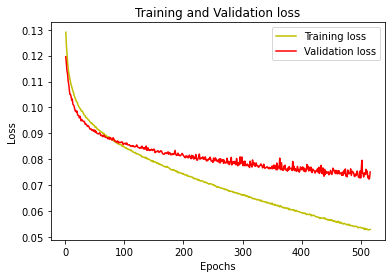

In [51]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

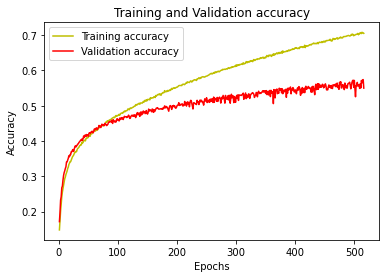

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score   support

       ANGER     0.5043    0.5781    0.5387       915
    CONTEMPT     0.6673    0.4269    0.5207       855
     DISGUST     0.6231    0.5350    0.5757       899
        FEAR     0.5112    0.5645    0.5365       930
   HAPPINESS     0.6576    0.6760    0.6667       855
     NEUTRAL     0.4934    0.3953    0.4390       946
     SADNESS     0.4766    0.6009    0.5316       932
    SURPRISE     0.5705    0.6555    0.6101       839

    accuracy                         0.5525      7171
   macro avg     0.5630    0.5540    0.5524      7171
weighted avg     0.5605    0.5525    0.5504      7171



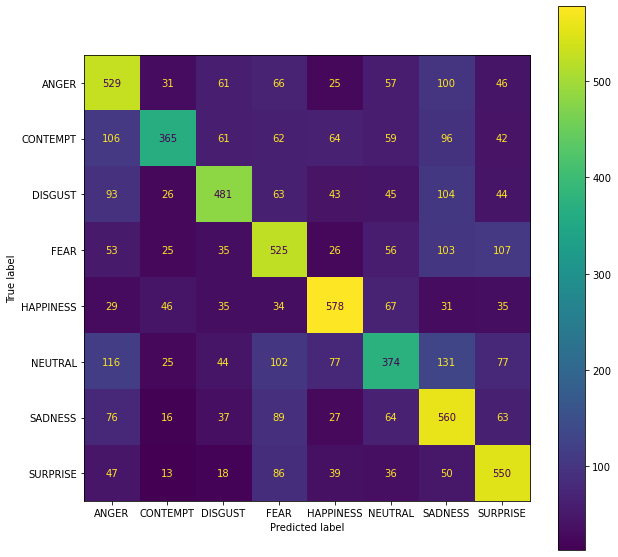

In [54]:
# test model
dictionary = {0: 'ANGER', 1: 'CONTEMPT', 2: 'DISGUST', 3: 'FEAR', 4: 'HAPPINESS',  5: 'NEUTRAL', 6: 'SADNESS', 7: 'SURPRISE'}
target_name = [dictionary[i] for i in range(len(dictionary))]

value = model.predict(X_test)
y_pred = np.argmax(value, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=target_name, digits=4))

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dictionary)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

SURPRISE
Epoch 1/220
414/414 - 15s - loss: 0.3039 - accuracy: 0.5658 - val_loss: 0.3220 - val_accuracy: 0.5541
Epoch 2/220
414/414 - 13s - loss: 0.2707 - accuracy: 0.6220 - val_loss: 0.1696 - val_accuracy: 0.7791
Epoch 3/220
414/414 - 13s - loss: 0.2522 - accuracy: 0.6544 - val_loss: 0.2729 - val_accuracy: 0.6255
Epoch 4/220
414/414 - 13s - loss: 0.2376 - accuracy: 0.6811 - val_loss: 0.1704 - val_accuracy: 0.7923
Epoch 5/220
414/414 - 13s - loss: 0.2273 - accuracy: 0.6991 - val_loss: 0.2599 - val_accuracy: 0.6711
Epoch 6/220
414/414 - 13s - loss: 0.2190 - accuracy: 0.7115 - val_loss: 0.1763 - val_accuracy: 0.7888
Epoch 7/220
414/414 - 13s - loss: 0.2113 - accuracy: 0.7238 - val_loss: 0.2046 - val_accuracy: 0.7542
Epoch 8/220
414/414 - 13s - loss: 0.2044 - accuracy: 0.7365 - val_loss: 0.1954 - val_accuracy: 0.7667
Epoch 9/220
414/414 - 13s - loss: 0.1991 - accuracy: 0.7454 - val_loss: 0.2075 - val_accuracy: 0.7548
Epoch 10/220
414/414 - 13s - loss: 0.1941 - accuracy: 0.7541 - val_loss: 

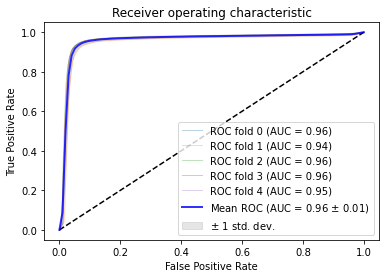

In [25]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for idx in range(len(dictionary)):
    print(dictionary[idx])

    emo_feature = np.copy(X_train)
    emo_target = list(label[idx] for label in y_train)
    emo_target = np.array(emo_target)

    X = emo_feature
    y = emo_target

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    for i, (train, val) in enumerate(cv.split(X, y)):
        X_train_kf, X_val_kf = X[train], X[val]
        y_train_kf, y_val_kf = y[train], y[val]

        le = preprocessing.LabelEncoder()
        y_train_kf = to_categorical(y_train_kf)
        y_val_kf = to_categorical(y_val_kf)

        model = create_model_best_param(best_params, 2)
        model.fit(X_train_kf,
                    y_train_kf,
                    validation_data=(X_val_kf, y_val_kf,),
                    batch_size=best_params['batch_size'],
                    epochs=best_params['epochs'],
                    verbose=2)

        # predict
        y_pred = model.predict(X_val_kf).ravel()
        y_val_kf = y_val_kf.ravel()

        print('====================Fold ', i , '====================')

        # plot ROC curve
        viz = RocCurveDisplay.from_predictions(y_val_kf, y_pred, ax=ax, name="ROC fold {}".format(i), alpha=0.3, lw=1,)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig(cwd + '/../graph/' + dictionary[idx] + '/ann_relu_crop.jpg')
    plt.show()